<span style="font-size:larger;">Malaria Detection</span>

The goal of this project is to detect wether a cell is infected with the malaria diseas or not. A total of 27,558 cell images are analyzed, whereas 50% are pictures of parasitized cells and 50% of uninfected cells.

In a first try, a Convolutional Neural Network (CNN) is trained which achieves a satisfying classification accuracy of 95%. 

In a second try, the image data is enhanced by altered cell images, and a second, deeper CNN is trained. The accuracy could be increased to 96% and the loss was discreased to 1/5 of the prior loss, resulting in an highly accurate and stable classifier.

In [1]:
import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt 
import seaborn as sns
from PIL import Image
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils import np_utils
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
# get image directory names
parasitized_data = glob.glob('../input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized/*.png')
uninfected_data = glob.glob('../input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/*.png')

The Visualization shows the parasitized and uninfected cell images. Short observation shows the following characteristics for each class:
* Uninfected cells: Normally of roundish shape and unicolored in light-blue, light-purple, purple, light-pink and pink. Can contain unpronounced white shadows.
* Parasitized cells: Look similar to the uninfected cells but usually contain a small and pronounced purple/pink mark or pattern.

PARASITIZED CELLS:


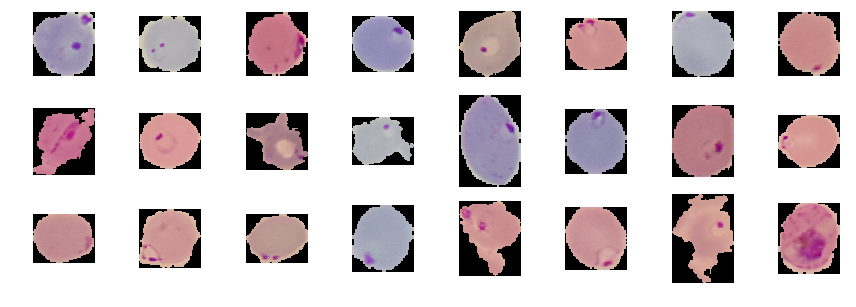

UNINFECTED CELLS:


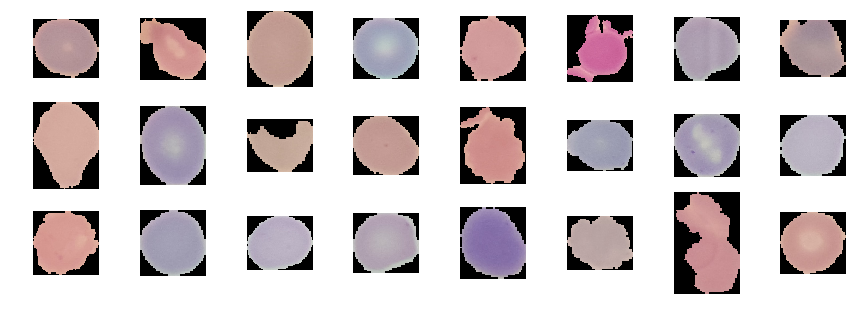

In [3]:
# Visualize Data
print('PARASITIZED CELLS:')
fig = plt.figure(figsize=(12,12))
for i in range(24):
    fig.add_subplot(3, 8, i+1)
    img = plt.imread(parasitized_data[i+100])
    plt.imshow(img)
    plt.tight_layout()
    plt.axis('off')
fig.subplots_adjust(hspace=-0.85)
plt.show()

print('UNINFECTED CELLS:')
fig = plt.figure(figsize=(12,12))
for i in range(24):
    fig.add_subplot(3, 8, i+1)
    img = plt.imread(uninfected_data[i+100])
    plt.imshow(img)
    plt.tight_layout()
    plt.axis('off')
fig.subplots_adjust(hspace=-0.85)
plt.show()

The data is preprocessed by downsizing the images to a 50x50 resolution and transforming the PIL image instance to a numpy array. The preprocessing functions are summed in a lambda expression to apply them without for-loop to the whole data. The label is created manually and encoded to a one-hot representation.

In [4]:
# Preprocess and organize data
preprocessing = lambda x: img_to_array(cv2.resize(plt.imread(x), (50, 50)))

data = []
labels = []

# apply preprocessing
parasitized_data_preprocessed = list(map(preprocessing, parasitized_data));
uninfected_data_preprocessed = list(map(preprocessing, uninfected_data));

# add preprocessed data to data list
data.extend(parasitized_data_preprocessed)
data.extend(uninfected_data_preprocessed)

# add labels to label list
labels.extend(np.ones((len(parasitized_data_preprocessed)), dtype=int))
labels.extend(np.zeros((len(uninfected_data_preprocessed)), dtype=int))

# transform into arrays
data = np.array(data)
labels = np.array(labels)
labels = np.reshape(labels, (len(labels),1))

# encode labels to one-hot
labels = np_utils.to_categorical(labels, num_classes = 2)

print(f'Shape Image Data: {data.shape}')
print(f'Shape Labels: {labels.shape}')

Shape Image Data: (27558, 50, 50, 3)
Shape Labels: (27558, 2)


A 80/20 split into training and test set seems appropriate for this amount of data.

In [5]:
# Divide datasets
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2)

print(f'Shape X-Train: {x_train.shape}')
print(f'Shape X-Test: {x_test.shape}')
print(f'Shape y-Train: {y_train.shape}')
print(f'Shape y-Test: {y_test.shape}')

Shape X-Train: (22046, 50, 50, 3)
Shape X-Test: (5512, 50, 50, 3)
Shape y-Train: (22046, 2)
Shape y-Test: (5512, 2)


In [6]:
import keras
from keras.layers import Dense, Conv2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.models import Sequential
from keras import backend as K
from keras import metrics
from keras import optimizers
from keras.callbacks import EarlyStopping

In [7]:
def CNNbuild(height, width, classes, channels):
    model = Sequential()
    
    inputShape = (height, width, channels)
    chanDim = -1
    
    if K.image_data_format() == 'channels_first':
        inputShape = (channels, height, width)
    model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = inputShape))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    
    model.add(Dense(512, activation = 'relu'))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation = 'softmax'))
    
    return model

The first CNN consist of three convolutional layers, a fully connected layer and a softmax output layer. Additionally, maxpooling and dropout and dropout-regularization was applied.

In [8]:
height = 50
width = 50
classes = 2
channels = 3
model = CNNbuild(height = height, width = width, classes = classes, channels = channels)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 11, 11, 32)       

In [9]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'] )
early_stopping = EarlyStopping(monitor='accuracy', patience=5)

In [10]:
h = model.fit(x_train, y_train, epochs = 20, batch_size = 32, callbacks = [early_stopping])

Epoch 1/20
22046/22046 [==============================] - 49s 2ms/step - loss: 0.6152 - accuracy: 0.7232
Epoch 2/20
22046/22046 [==============================] - 49s 2ms/step - loss: 0.2221 - accuracy: 0.9170
Epoch 3/20
22046/22046 [==============================] - 49s 2ms/step - loss: 0.1837 - accuracy: 0.9363
Epoch 4/20
22046/22046 [==============================] - 48s 2ms/step - loss: 0.1688 - accuracy: 0.9424
Epoch 5/20
22046/22046 [==============================] - 48s 2ms/step - loss: 0.1655 - accuracy: 0.9442
Epoch 6/20
22046/22046 [==============================] - 52s 2ms/step - loss: 0.1601 - accuracy: 0.9473
Epoch 7/20
22046/22046 [==============================] - 48s 2ms/step - loss: 0.1602 - accuracy: 0.9485
Epoch 8/20
22046/22046 [==============================] - 48s 2ms/step - loss: 0.1541 - accuracy: 0.9499
Epoch 9/20
22046/22046 [==============================] - 50s 2ms/step - loss: 0.1486 - accuracy: 0.9514
Epoch 10/20
22046/22046 [==============================

The model shows a loss of 0.151 and a test set accuracy of 95%. This matches the training set accuracy, indicating that overfitting is not an issue using this classifier.

In [11]:
predictions = model.evaluate(x_test, y_test)
print(f'LOSS : {predictions[0]}')
print(f'ACCURACY : {predictions[1]}')

5512/5512 [==============================] - 4s 639us/step
LOSS : 0.15194497979820554
ACCURACY : 0.9537373185157776


The ROC-curve shows that the prediction is close to optimal.

The confusion matrix shows that more cells are predicted false negative than are predicted false positive. When detecting a possibly terminal condition, the false negative value should be close to zero. The ROC-curve shows that false positive predictions can be "traded" for false negative predictions by changing the decision boundary without losing significant overall accuracy.

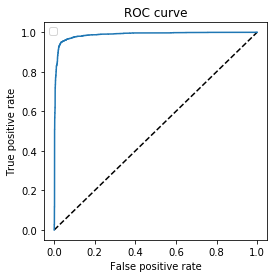

AUC: 0.9869660536886383
Confusion Matrix: [[2663   71]
 [ 184 2594]]


In [12]:
# Confusion matrix and ROC-Curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_pred = model.predict(x_test)[:,1]
y_pred_int = np.rint(y_pred)

conf = confusion_matrix(y_test[:,1], y_pred_int)

fpr, tpr, thresholds = roc_curve(y_test[:,1], y_pred)
plt.figure(figsize=(4,4))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

auc_ = auc(fpr, tpr)
print(f'AUC: {auc_}')
print(f'Confusion Matrix: {conf}')

Looking into the falsely classified images shows the following:
* False positive cells: The cells either contain purple marks or pattern, which are characteristic for parasitized cells or unusual forms.
* False negative cells: The cells contain unpronounced or no purple marks

Following this, it would be hard to impossible for a human being to predict the displayed cells correctly. The classifier operates close to human-like performance.

FALSE POSITIVE:


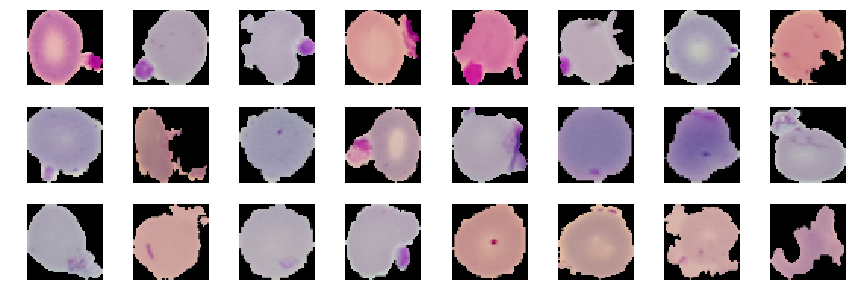

FALSE NEGATIVE:


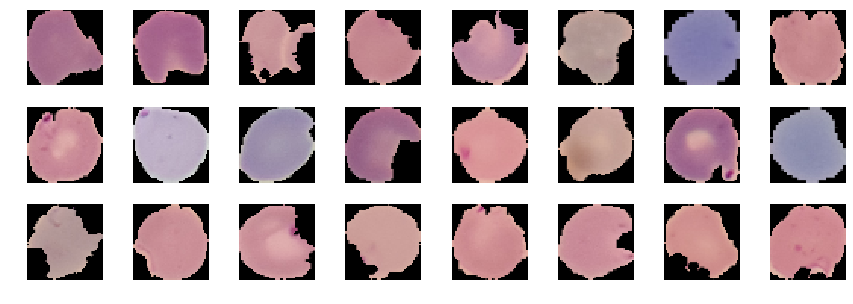

In [13]:
# analyze falsly predicted images
ind_fp = np.where((y_test[:,1]-y_pred_int) == -1)[0]
ind_fn = np.where((y_test[:,1]-y_pred_int) == 1)[0]

print('FALSE POSITIVE:')
fig = plt.figure(figsize=(12,12))
for i in range(24):
    fig.add_subplot(3, 8, i+1)
    plt.imshow(x_test[ind_fp[i]]) 
    plt.tight_layout()
    plt.axis('off')
fig.subplots_adjust(hspace=-0.85)
plt.show()

print('FALSE NEGATIVE:')
fig = plt.figure(figsize=(12,12))
for i in range(24):
    fig.add_subplot(3, 8, i+1)
    plt.imshow(x_test[ind_fn[i]]) 
    plt.tight_layout()
    plt.axis('off')
fig.subplots_adjust(hspace=-0.85)
plt.show()

Nevertheless, I tried to improve the classifier by enhancing the data set with distorted images.

In [14]:
# Augment Data
from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims

train_datagen = ImageDataGenerator(width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   zoom_range=0.02,
                                   rotation_range=22.5,
                                   channel_shift_range=0.3,
                                   fill_mode="nearest")
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(x_train, y_train, batch_size = 64, shuffle = False)
val_generator = val_datagen.flow(x_test, y_test, batch_size = 64, shuffle = False)

The distortion of the added images is shown below. The pictures were shifted in height and width, flipped horizontally and vertically, zoomed, rotated and color-shifted. 
The lines at the cell edges are intended to create more "unusual" cell forms. Using augmented images for training a classifier allows us to use deeper networks and less regularization without overfitting, as the classifier is tested on not augmented images.

ORIGINAL IMAGE:


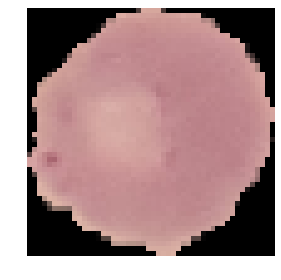

AUGMENTED IMAGES:


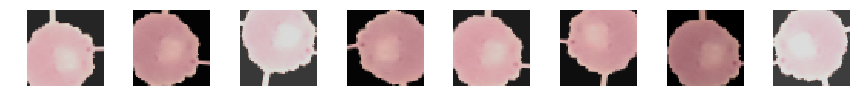

In [15]:
# Show augmented Data
pic = x_train[333]

print('ORIGINAL IMAGE:')
plt.imshow(pic)
plt.axis('off')
plt.tight_layout()
plt.show()

pic = expand_dims(pic, 0)
it = train_datagen.flow(pic, batch_size=1)

print('AUGMENTED IMAGES:')
fig = plt.figure(figsize=(12,12))
for i in range(8):
    plt.subplot(1, 8, i+1)
    batch = it.next()
    plt.imshow(batch[0])
    plt.axis('off')
plt.tight_layout()
plt.show()

The CNN model is enhanced by an extra layer to keep up with the wider range of cell image styles. In addition, the regularization was waived. Regularization in this case is ot necessary as the model is fit on the distorted cell images but applied to not distorted images.

In [16]:
# Enhance model to handle more diverse data
def CNNbuild_aug(height, width, classes, channels):
    model = Sequential()
    
    inputShape = (height, width, channels)
    chanDim = -1
    
    if K.image_data_format() == 'channels_first':
        inputShape = (channels, height, width)
    model.add(Conv2D(16, (3,3), activation = 'relu', input_shape = inputShape))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    
    model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = inputShape))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))

    model.add(Conv2D(64, (3,3), activation = 'relu'))
    model.add(BatchNormalization(axis = chanDim))

    model.add(Conv2D(128, (3,3), activation = 'relu'))
    model.add(BatchNormalization(axis = chanDim))
    
    model.add(Conv2D(128, (3,3), activation = 'relu'))
    model.add(BatchNormalization(axis = chanDim))
    
    model.add(Flatten())
    
    model.add(Dense(512, activation = 'relu'))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dense(classes, activation = 'softmax'))
    
    return model

In [17]:
model_aug = CNNbuild_aug(height = height, width = width, classes = classes, channels = channels)
model_aug.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
early_stopping = EarlyStopping(monitor='accuracy', patience=5)

In [18]:
h_aug = model_aug.fit_generator(train_generator, steps_per_epoch = len(x_train) // 64, epochs = 40,
                                callbacks = [early_stopping])

Epoch 1/40
344/344 [==============================] - 60s 174ms/step - loss: 0.4406 - accuracy: 0.8147
Epoch 2/40
344/344 [==============================] - 58s 169ms/step - loss: 0.2286 - accuracy: 0.9179
Epoch 3/40
344/344 [==============================] - 58s 169ms/step - loss: 0.1971 - accuracy: 0.9339
Epoch 4/40
344/344 [==============================] - 59s 170ms/step - loss: 0.1907 - accuracy: 0.9359
Epoch 5/40
344/344 [==============================] - 58s 168ms/step - loss: 0.1825 - accuracy: 0.9396
Epoch 6/40
344/344 [==============================] - 58s 169ms/step - loss: 0.1748 - accuracy: 0.9433
Epoch 7/40
344/344 [==============================] - 58s 169ms/step - loss: 0.1696 - accuracy: 0.9446
Epoch 8/40
344/344 [==============================] - 58s 167ms/step - loss: 0.1691 - accuracy: 0.9426
Epoch 9/40
344/344 [==============================] - 58s 168ms/step - loss: 0.1655 - accuracy: 0.9453
Epoch 10/40
344/344 [==============================] - 58s 167ms/step - l

The new classifier shows an increase of accuracy by one percent.
Interesting is the drop of the new classifiers loss to 1/5 of the origial loss. This shows the network is much more confident about the decisions it makes and therefore more robust.

In [19]:
predict = model_aug.evaluate_generator(val_generator)
print(f'LOSS : {predict[0]}')
print(f'ACCURACY : {predict[1]}')

LOSS : 0.03187132254242897
ACCURACY : 0.9593613743782043


The ROC curves shows that the classifier found a good cut-off point between classifying into parasitized and uninfected cells.

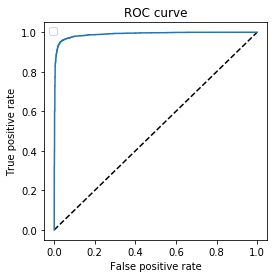

AUC: 0.9898728145640082
Confusion Matrix: [[2623  111]
 [ 113 2665]]


In [20]:
# ROC Kurve, AUC
y_pred = model_aug.predict_generator(val_generator)[:,1] # using val_generator to get y_pred
y_pred_int = np.rint(y_pred)
y_true = val_generator.y[:,1]

conf = confusion_matrix(y_true, y_pred_int)

fpr, tpr, thresholds = roc_curve(y_true, y_pred)

plt.figure(figsize=(4,4))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

auc_ = auc(fpr, tpr)
print(f'AUC: {auc_}')
print(f'Confusion Matrix: {conf}')